## Assignment-4
### Pradeep Mundlik AI21BTECH11022

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt 
%matplotlib inline

### Dataset Creation

In [16]:
# defining dataloader to generate N samples of length between 2 to 9
def dataloader(N):

    #list to store datasamples
    X = []

    #list to store ground truth
    Y = []

    for i in range(N):

        #random length
        l = np.random.randint(low=2,high=10)

        # creating rand tenosr of length l where all values are <1
        x = torch.rand(l)

        # assigning 1 to first two values in 2nd dimension and 0 to rest
        bits = torch.zeros(l)
        bits[0] = 1
        bits[1] = 1
        Y.append(x[0]+x[1])

        # shuffle index
        index = np.arange(l)
        np.random.shuffle(index)

        # apply shuffled index
        x = x[index]
        bits = bits[index]

        # concatinating x and corresponding bits
        x = x.reshape([l,1])
        bits = bits.reshape([l,1])

        X.append(torch.concat([x,bits],dim=1))
    
    return X,Y

# creating 5000 datasamples
X,Y = dataloader(5000)
X[:2],Y[:2]

([tensor([[0.8738, 0.0000],
          [0.6502, 0.0000],
          [0.3797, 0.0000],
          [0.3813, 0.0000],
          [0.7694, 1.0000],
          [0.0468, 0.0000],
          [0.4582, 1.0000]]),
  tensor([[0.9196, 0.0000],
          [0.3011, 1.0000],
          [0.2079, 1.0000],
          [0.1258, 0.0000]])],
 [tensor(1.2275), tensor(0.5090)])

### Baseline

In [17]:
def baseline(Y):
    # converting Y truth to tensor
    Y = torch.tensor(Y)

    # applying MSE to Y predicted i.e. 1 and Y truth
    loss = (1-Y)**2
    loss = loss.mean()
    return loss.item()
    
print(f'Baseline loss is {baseline(Y)}')

Baseline loss is 0.1665470153093338


### Elmon RNN

In [18]:
class Elmon:
    def __init__(self,sequence_length=9,learning_rate=1e-2):

        # length of sequence 
        self.sequence_length = sequence_length

        # dimension of hidden layer
        self.h = 1

        # dimension of output 
        self.n = 2

        self.lr = learning_rate

        # initializing weights
        self.W_xh = torch.rand([self.h,self.n],requires_grad=True) # between input and hidden layer
        self.W_hh = torch.rand([self.h,self.h],requires_grad=True) #  within hidden layer 
        self.Wy = torch.rand(self.h,requires_grad=True) # between hiddden layer and output

        # initializing biaases
        self.bh = torch.rand(self.h,requires_grad=True) # for hidden unit
        self.by = torch.rand(1,requires_grad=True) # for output unit

        # predicted Y
        self.y_p = torch.empty(self.h)
        self.y_p.requires_grad = True

        # list of all parameters 
        self.paramerters = [self.W_xh,self.W_hh,self.bh,self.Wy,self.by]

    def forward(self,X):
        
        self.sequence_length = X.shape[0]

        # variable to store value of current hidden state
        self.hidden = torch.empty(self.h).fill_(0)
        
        for i in range(self.sequence_length):
            
            if(i==0):
                self.hidden = torch.matmul(self.W_xh,X[i]) + self.bh
                continue

            self.hidden = torch.matmul(self.W_xh,X[i]) + torch.matmul(self.W_hh,self.hidden) + self.bh
        
        self.y_p = torch.matmul(self.hidden,self.Wy) + self.by

        return self.y_p

    def fit(self,X,Y):

        # optimizer 
        optimizer = torch.optim.SGD(self.paramerters, lr=self.lr)

        # max_epochs
        max_epochs = 10

        # Number of data samples
        N = len(X)

        # list to store loss at end of each epoch
        L = []

        for epoch in range(max_epochs):
            
            loss = 0 # loss of current sample 
            l = 0 # to store avg loss

            for i in range(N):

                # forward pass
                self.forward(X[i])

                # calculate loss
                loss = (self.y_p-Y[i])**2

                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                l += loss

            # apeend avg loss
            L.append(l.item()/N)
            
            print(f'Mean loss at end of epoch-{epoch+1} is {L[epoch]}')
        
        return L
                    

In [36]:
elmon = Elmon()
L_elmon = elmon.fit(X,Y)

Mean loss at end of epoch-1 is 0.1436184326171875
Mean loss at end of epoch-2 is 0.11199913330078125
Mean loss at end of epoch-3 is 0.1079361328125
Mean loss at end of epoch-4 is 0.10691629638671875
Mean loss at end of epoch-5 is 0.1064461181640625
Mean loss at end of epoch-6 is 0.10617711181640625
Mean loss at end of epoch-7 is 0.10600489501953125
Mean loss at end of epoch-8 is 0.10588768310546876
Mean loss at end of epoch-9 is 0.10580355224609375
Mean loss at end of epoch-10 is 0.10574169921875


#### Plot for ELmon

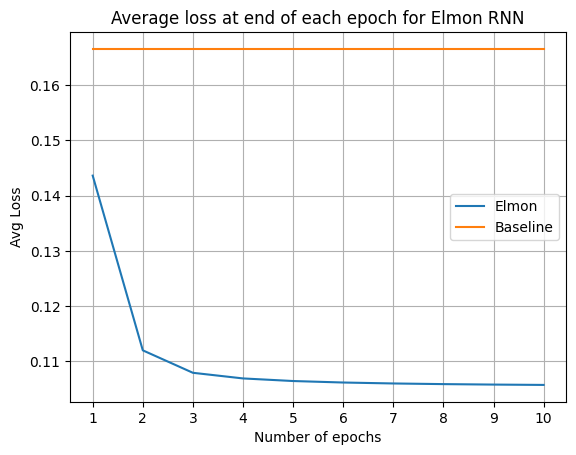

In [37]:
plt.plot(np.arange(1,11),L_elmon,label='Elmon')
plt.plot(np.arange(1,11),10*[baseline(Y)],label='Baseline')
plt.title('Average loss at end of each epoch for Elmon RNN')
plt.xlabel('Number of epochs')
plt.ylabel('Avg Loss')
plt.xticks(np.arange(1,11))
plt.grid()
plt.legend()
plt.show()

### LSTM

In [21]:
class LSTM:
    def __init__(self, sequence_length=9, learning_rate=1e-2):

        self.sequence_length = sequence_length
        self.lr = learning_rate

        self.h = 1
        self.n = 2

        # initializing weights
        self.W_i = torch.rand([self.h, (self.h+self.n)], requires_grad=True)
        self.W_f = torch.rand([self.h, (self.h+self.n)], requires_grad=True)
        self.W_o = torch.rand([self.h, (self.h+self.n)], requires_grad=True)
        self.W_c = torch.rand([self.h, (self.h+self.n)], requires_grad=True)

        # initializing biases
        self.b_i = torch.rand(self.h, requires_grad=True)
        self.b_f = torch.rand(self.h, requires_grad=True)
        self.b_o = torch.rand(self.h, requires_grad=True)
        self.b_c = torch.rand(self.h, requires_grad=True)

        self.Wy = torch.rand(self.h, requires_grad=True)
        self.by = torch.rand(self.h, requires_grad=True)

        # list of all parameters
        self.parameters = [self.W_i, self.b_i, self.W_f, self.b_f,
                           self.W_o, self.b_o, self.W_c, self.b_c, self.Wy, self.by]

    def sigmoid(self, t):
        return 1 / (1 + torch.exp(-1*t))

    def forward(self, X):

        self.sequence_length = X.shape[0]

        # var to store value of current hidden state
        self.hidden = torch.empty(self.h).fill_(0)

        # var to store value of current cell state
        self.cell = torch.empty(self.h).fill_(0)

        for t in range(1, self.sequence_length):

            # concatinating input and previous hidden state
            concat = torch.concat([self.hidden, X[t]], dim=0)

            # calculating values for all gates
            i = self.sigmoid(torch.matmul(self.W_i, concat) + self.b_i)
            f = self.sigmoid(torch.matmul(self.W_f, concat) + self.b_f)
            o = self.sigmoid(torch.matmul(self.W_o, concat) + self.b_o)
            c = torch.tanh(torch.matmul(self.W_c, concat) + self.b_c)

            # calculating current cell state and hidden state
            self.cell = torch.mul(f, self.cell) + torch.mul(i, c)
            self.hidden = torch.mul(o, torch.tanh(self.cell))

        self.y_p = torch.matmul(self.hidden, self.Wy) + self.by

        return self.y_p

    def fit(self, X, Y):

        optimizer = torch.optim.SGD(self.parameters, lr=self.lr)

        max_epochs = 10

        # number of data samples
        N = len(X)

        # list to store avg loss
        L = []

        for epoch in range(max_epochs):

            loss = 0  # loss for current sample
            l = 0  # avg loss

            for i in range(N):

                # forward pass
                self.forward(X[i])

                loss = (self.y_p-Y[i])**2

                # backward loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                l += loss

            L.append(l.item()/N)

            print(f'Mean loss at end of epoch-{epoch+1} is {L[epoch]}')

        return L


In [29]:
lstm = LSTM()
L_lstm = lstm.fit(X,Y)

Mean loss at end of epoch-1 is 0.16808514404296876
Mean loss at end of epoch-2 is 0.13195775146484376
Mean loss at end of epoch-3 is 0.09889703369140625
Mean loss at end of epoch-4 is 0.07631648559570313
Mean loss at end of epoch-5 is 0.05932621459960938
Mean loss at end of epoch-6 is 0.051365625
Mean loss at end of epoch-7 is 0.04759630126953125
Mean loss at end of epoch-8 is 0.045495928955078126
Mean loss at end of epoch-9 is 0.04415910949707031
Mean loss at end of epoch-10 is 0.04322716979980469


#### Plot for LSTM

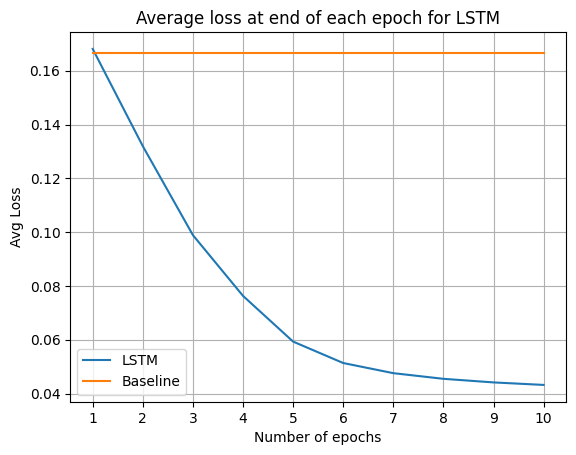

In [30]:
plt.plot(np.arange(1,11),L_lstm,label='LSTM')
plt.plot(np.arange(1,11),10*[baseline(Y)],label='Baseline')
plt.title('Average loss at end of each epoch for LSTM')
plt.xlabel('Number of epochs')
plt.ylabel('Avg Loss')
plt.xticks(np.arange(1,11))
plt.grid()
plt.legend()
plt.show()

### GRU

In [24]:
class GRU:
    def __init__(self, sequence_length=9, learning_rate=1e-2):

        self.sequence_length = sequence_length
        self.lr = learning_rate

        self.h = 1
        self.n = 2

        # initalizing weights
        self.W_r = torch.rand([self.h, (self.h+self.n)],requires_grad=True)
        self.W_z = torch.rand([self.h, (self.h+self.n)],requires_grad=True)
        self.W_h = torch.rand([self.h, (self.h+self.n)],requires_grad=True)

        self.b_r = torch.rand(self.h,requires_grad=True)
        self.b_z = torch.rand(self.h,requires_grad=True)
        self.b_h = torch.rand(self.h,requires_grad=True)

        self.Wy = torch.rand(self.h,requires_grad=True)
        self.by = torch.rand(1,requires_grad=True)
        
        # list of all parameters
        self.parameters = [self.W_r, self.b_r, self.W_z,
                           self.b_z, self.W_h, self.b_h, self.Wy, self.by]

    def sigmoid(self, t):
        return 1 / (1 + torch.exp(-1*t))

    def forward(self, X):

        self.sequence_length = X.shape[0]
        self.hidden = torch.empty(self.h).fill_(0)

        for t in range(1, self.sequence_length):

            # concatinating input and previous hidden state
            concat = torch.concat([self.hidden, X[t]], dim=0)

            # calculating values for all gates
            r = self.sigmoid(torch.matmul(self.W_r, concat) + self.b_r)
            z = self.sigmoid(torch.matmul(self.W_z, concat) + self.b_z)
            h = torch.tanh(torch.matmul(self.W_h, torch.concat([torch.mul(r, self.hidden),X[t]]))+self.b_h)

            # calculating hidden state
            self.hidden = torch.mul(z, self.hidden) + torch.mul(1-z, h)

        self.y_p = torch.matmul(self.hidden, self.Wy) + self.by

        return self.y_p

    def fit(self, X, Y):

        optimizer = torch.optim.SGD(self.parameters, lr=self.lr)

        max_epochs = 10

        # number of data samples
        N = len(X)

        # list to store avg loss
        L = []

        for epoch in range(max_epochs):
            
            loss = 0 # loss for current sample
            l = 0 # avg loss

            for i in range(N):

                # forward pass
                self.forward(X[i])

                loss = (self.y_p-Y[i])**2

                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                l += loss

            L.append(l.item()/N)
            
            print(f'Mean loss at end of epoch-{epoch+1} is {L[epoch]}')

        return L

In [31]:
gru = GRU()
L_gru = gru.fit(X,Y)

Mean loss at end of epoch-1 is 0.161218310546875
Mean loss at end of epoch-2 is 0.1114160400390625
Mean loss at end of epoch-3 is 0.07339696655273438
Mean loss at end of epoch-4 is 0.05309225463867188
Mean loss at end of epoch-5 is 0.04621327819824219
Mean loss at end of epoch-6 is 0.04354916076660156
Mean loss at end of epoch-7 is 0.04224257507324219
Mean loss at end of epoch-8 is 0.04148720092773438
Mean loss at end of epoch-9 is 0.040998187255859374
Mean loss at end of epoch-10 is 0.04065490112304687


#### Plot for GRU

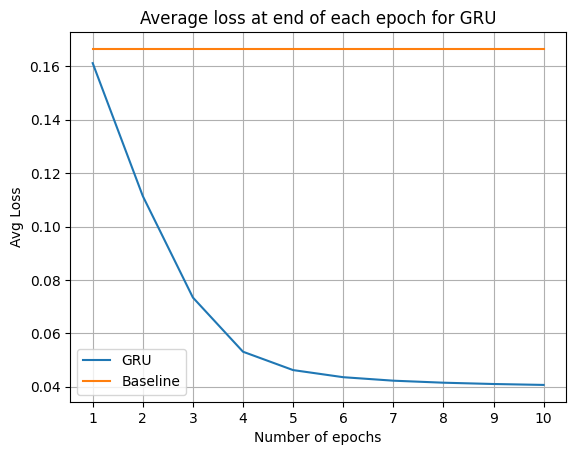

In [32]:
plt.plot(np.arange(1,11),L_gru,label='GRU')
plt.plot(np.arange(1,11),10*[baseline(Y)],label='Baseline')
plt.title('Average loss at end of each epoch for GRU')
plt.xlabel('Number of epochs')
plt.ylabel('Avg Loss')
plt.xticks(np.arange(1,11))
plt.grid()
plt.legend()
plt.show()

### Plot of Comparison

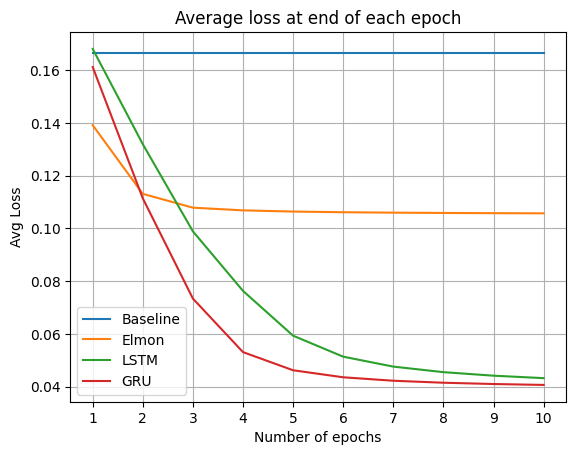

In [34]:
plt.plot(np.arange(1,11),10*[baseline(Y)],label='Baseline')
plt.plot(np.arange(1,11),L_elmon,label='Elmon')
plt.plot(np.arange(1,11),L_lstm,label='LSTM')
plt.plot(np.arange(1,11),L_gru,label='GRU')
plt.title('Average loss at end of each epoch')
plt.xlabel('Number of epochs')
plt.ylabel('Avg Loss')
plt.xticks(np.arange(1,11))
plt.grid()
plt.legend()
plt.show()